# Bibliotecas
---

In [ ]:
# Instala bibliotecas
!pip install skforecast==0.13.0 --quiet
!pip install pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.3 MB/s eta 0:00:00


In [ ]:
# Importa bibliotecas

# Processamento de dados
import pandas as pd

# Análise de dados
import statsmodels.api as sm

# Modelagem e previsão
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.ForecasterBaseline import ForecasterEquivalentDate
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals
from pmdarima import auto_arima

# Organização de dados
---

In [ ]:
# Importa dados online
dados = pd.read_parquet("https://drive.google.com/uc?export=download&id=1KyT5U0yXXsNF-oDjjRtefnf1aN5YfxKq")

# Separa dados de interesse
dados_desemprego = dados.tx_desemprego.dropna().asfreq("MS")
dados_desemprego

data
2012-04-01    7.8
2012-05-01    7.7
2012-06-01    7.6
2012-07-01    7.5
2012-08-01    7.4
             ... 
2023-12-01    7.4
2024-01-01    7.6
2024-02-01    7.8
2024-03-01    7.9
2024-04-01    7.5
Freq: MS, Name: tx_desemprego, Length: 145, dtype: float64

# Visualização de dados
---

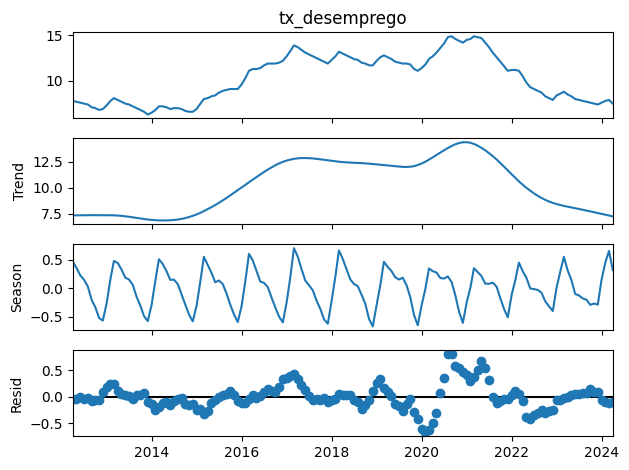

In [ ]:
# Decomposição da série
sm.tsa.STL(dados_desemprego).fit().plot();

Série claramente não estacionária, sazonal, com tendência.


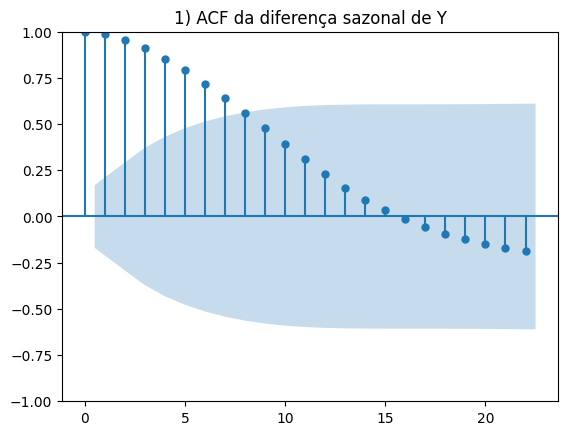

In [ ]:
# Análise de autocorrelação
sm.graphics.tsa.plot_acf(
    x = dados_desemprego.diff(12).dropna(),
    title = "1) ACF da diferença sazonal de Y"
    );

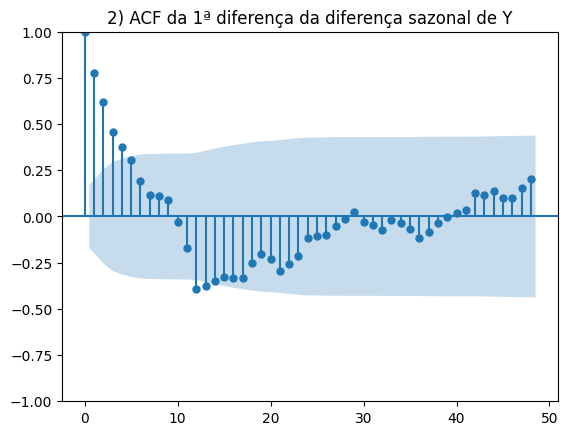

In [ ]:
sm.graphics.tsa.plot_acf(
    x = dados_desemprego.diff(12).diff().dropna(),  lags = 48,
    title = "2) ACF da 1ª diferença da diferença sazonal de Y"
    );

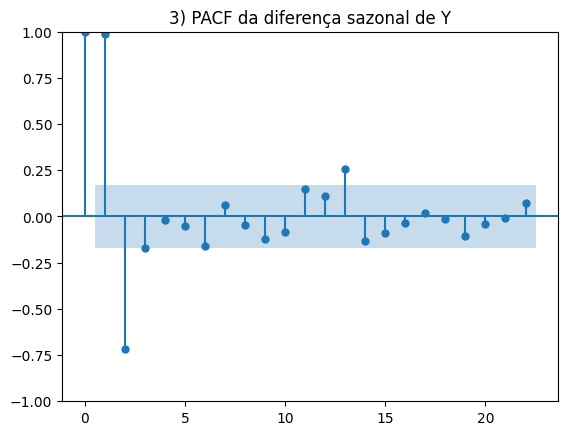

In [ ]:
sm.graphics.tsa.plot_pacf(
    x = dados_desemprego.diff(12).dropna(),
    title = "3) PACF da diferença sazonal de Y"
    );

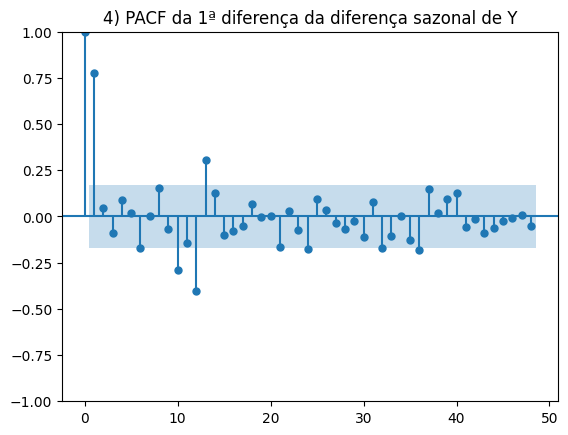

In [ ]:
sm.graphics.tsa.plot_pacf(
    x = dados_desemprego.diff(12).diff().dropna(), lags = 48,
    title = "4) PACF da 1ª diferença da diferença sazonal de Y"
    );

# Especificação do modelo
---

**Pela ACF** (gráfico 2):
- O pico significativo no lag 1 sugere um componente MA(1)
- O pico significativo no lag 12 sugere um componente SMA(1)

**Pela PACF** (gráfico 4):
- O pico significativo no lag 1 sugere um componente AR(1)
- O pico significativo no lag 12 sugere um componente SAR(1)

Estes padrões sugerem os seguintes **modelos candidatos**:

- ARIMA(0,1,1)(0,1,1)
- ARIMA(1,1,0)(0,1,1)



# Estimação do modelo
---



- Objetivo: encontrar o modelo que fornece as previsões mais acuradas
- Horizonte de previsão: 12 meses
- Estratégia de previsão: validação cruzada com reestimação e janela de treino crescente
- Modelos a serem testados:
  - SARIMA encontrado nas ACF/PACF
  - Auto SARIMA
  - Passeio Aleatório Sazonal


In [ ]:
# Define parâmetros para validação cruzada
h = 12
janela_inicial = int(dados_desemprego.shape[0]*0.5)
janela_inicial

72

In [ ]:
# Busca especificação ótima pelo algoritmo Auto SARIMA
arima_aic = auto_arima(y = dados_desemprego, m = h, trace = True)
arima_aic

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-113.982, Time=3.93 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=73.794, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-78.591, Time=0.86 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-12.173, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=71.801, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-65.223, Time=0.72 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-81.879, Time=7.68 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-114.716, Time=13.85 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-105.509, Time=5.02 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=-115.249, Time=3.11 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=-113.571, Time=2.84 sec
 ARIMA(1,1,2)(2,0,2)[12] intercept   : AIC=-115.969, Time=2.91 sec
 ARIMA(1,1,2)(1,0,2)[12] intercept   : AIC=-111.721, Time=5.69 sec
 ARIMA(1,1,2)(2,0,1)[12] intercept   : AIC=-114.584, Time=2.52 sec
 ARIMA(1,1,2)(1,0,1)[12] i

ARIMA(order=(1, 1, 3), scoring_args={}, seasonal_order=(1, 0, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [ ]:
# Especificação ótima do Auto SARIMA
print(arima_aic.order)
print(arima_aic.seasonal_order)

(1, 1, 3)
(1, 0, 1, 12)


In [ ]:
# Busca melhor especificação entre modelos candidatos SARIMA
sarima = ForecasterSarimax(regressor = Sarimax(maxiter = 500))

parametros_sarima = {
    "order": [(0,1,1), (1,1,0), arima_aic.order],
    "seasonal_order": [(0,1,1,12), (0,1,1,12), arima_aic.seasonal_order],
    "trend": [None, "c", "t", "ct"]
}

busca_sarima = grid_search_sarimax(
    forecaster         = sarima,
    y                  = dados_desemprego,
    param_grid         = parametros_sarima,
    steps              = h,
    metric             = "mean_squared_error",
    initial_train_size = janela_inicial,
    fixed_train_size   = False,
    refit              = True,
    verbose            = False
)

busca_sarima.head(10)

Number of models compared: 36.


params grid:   0%|          | 0/36 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (1, 1, 0), 'seasonal_order': (0, 1, 1, 12), 'trend': None}
  Backtesting metric: 1.69071439117291



,params,mean_squared_error,order,seasonal_order,trend
16,"{'order': (1, 1, 0), 'seasonal_order': (0, 1, ...",1.690714,"(1, 1, 0)","(0, 1, 1, 12)",None
12,"{'order': (1, 1, 0), 'seasonal_order': (0, 1, ...",1.690714,"(1, 1, 0)","(0, 1, 1, 12)",None
24,"{'order': (1, 1, 3), 'seasonal_order': (0, 1, ...",1.782046,"(1, 1, 3)","(0, 1, 1, 12)",None
28,"{'order': (1, 1, 3), 'seasonal_order': (0, 1, ...",1.782046,"(1, 1, 3)","(0, 1, 1, 12)",None
20,"{'order': (1, 1, 0), 'seasonal_order': (1, 0, ...",1.814883,"(1, 1, 0)","(1, 0, 1, 12)",None
21,"{'order': (1, 1, 0), 'seasonal_order': (1, 0, ...",1.834651,"(1, 1, 0)","(1, 0, 1, 12)",c
32,"{'order': (1, 1, 3), 'seasonal_order': (1, 0, ...",1.904890,"(1, 1, 3)","(1, 0, 1, 12)",None
33,"{'order': (1, 1, 3), 'seasonal_order': (1, 0, ...",1.931238,"(1, 1, 3)","(1, 0, 1, 12)",c
13,"{'order': (1, 1, 0), 'seasonal_order': (0, 1, ...",1.973649,"(1, 1, 0)","(0, 1, 1, 12)",c
17,"{'order': (1, 1, 0), 'seasonal_order': (0, 1, ...",1.973649,"(1, 1, 0)","(0, 1, 1, 12)",c


In [ ]:
# Validação cruzada do melhor modelo SARIMA
vc_sarima = backtesting_sarimax(
    forecaster         = sarima,
    y                  = dados_desemprego,
    steps              = h,
    metric             = "mean_squared_error",
    initial_train_size = janela_inicial,
    fixed_train_size   = False,
    refit              = True,
    verbose            = True
)
print(f"Erro de validação cruzada: {vc_sarima[0]}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 72
Number of observations used for backtesting: 73
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2012-04-01 00:00:00 -- 2018-03-01 00:00:00  (n=72)
    Validation: 2018-04-01 00:00:00 -- 2019-03-01 00:00:00  (n=12)
Fold: 1
    Training:   2012-04-01 00:00:00 -- 2019-03-01 00:00:00  (n=84)
    Validation: 2019-04-01 00:00:00 -- 2020-03-01 00:00:00  (n=12)
Fold: 2
    Training:   2012-04-01 00:00:00 -- 2020-03-01 00:00:00  (n=96)
    Validation: 2020-04-01 00:00:00 -- 2021-03-01 00:00:00  (n=12)
Fold: 3
    Training:   2012-04-01 00:00:00 -- 2021-03-01 00:00:00  (n=108)
    Validation: 2021-04-01 00:00:00 -- 2022-03-01 00:00:00  (n=12)
Fold: 4
    Training:   2012-04-01 00:00:00 -- 

  0%|          | 0/7 [00:00<?, ?it/s]

Erro de validação cruzada:    mean_squared_error
0            1.690714


In [ ]:
# Validação cruzada do modelo Passeio Aleatório Sazonal
srw = ForecasterEquivalentDate(offset = h)

vc_srw = backtesting_forecaster(
    forecaster         = srw,
    y                  = dados_desemprego,
    steps              = h,
    metric             = "mean_squared_error",
    initial_train_size = janela_inicial,
    fixed_train_size   = False,
    refit              = True,
    verbose            = True
)
print(f"Erro de validação cruzada: {vc_srw[0]}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 72
Number of observations used for backtesting: 73
    Number of folds: 7
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude from the end of each train set before test (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2012-04-01 00:00:00 -- 2018-03-01 00:00:00  (n=72)
    Validation: 2018-04-01 00:00:00 -- 2019-03-01 00:00:00  (n=12)
Fold: 1
    Training:   2012-04-01 00:00:00 -- 2019-03-01 00:00:00  (n=84)
    Validation: 2019-04-01 00:00:00 -- 2020-03-01 00:00:00  (n=12)
Fold: 2
    Training:   2012-04-01 00:00:00 -- 2020-03-01 00:00:00  (n=96)
    Validation: 2020-04-01 00:00:00 -- 2021-03-01 00:00:00  (n=12)
Fold: 3
    Training:   2012-04-01 00:00:00 -- 2021-03-01 00:00:00  (n=108)
    Validation: 2021-04-01 00:00:00 -- 2022-03-01 00:00:00  (n=12)
Fold: 4
    Training:   2012-04-01 00:00:00 -- 

  0%|          | 0/7 [00:00<?, ?it/s]

Erro de validação cruzada:    mean_squared_error
0            4.792877


# Avaliação da performance
---

In [ ]:
# Compara erros de modelos
print("Erro Quadrático Médio (MSE) de validação cruzada:")
print(f"  ARIMA{sarima.params['order']}{sarima.params['seasonal_order']}: {vc_sarima[0].iloc[0].round(3).values[0]}")
print(f"  Passeio Aleatório Sazonal: {vc_srw[0].iloc[0].round(3).values[0]}")

Erro Quadrático Médio (MSE) de validação cruzada:
  ARIMA(1, 1, 0)(0, 1, 1, 12): 1.691
  Passeio Aleatório Sazonal: 4.793


<Axes: >

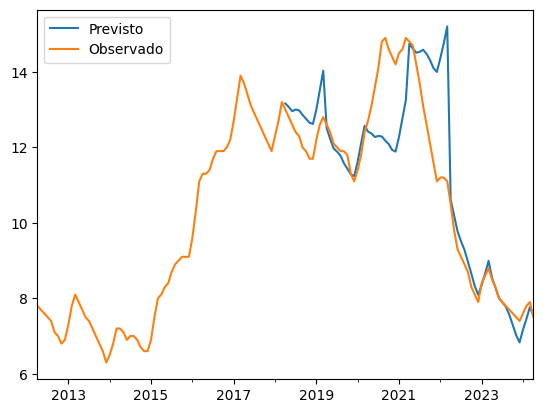

In [ ]:
# Compara valores observados vs. previstos
pd.concat(
    [vc_sarima[1]["pred"].rename("Previsto"),
     dados_desemprego.rename("Observado")],
    axis = "columns"
    ).plot()

Média dos resíduos: -0.12734627319593692


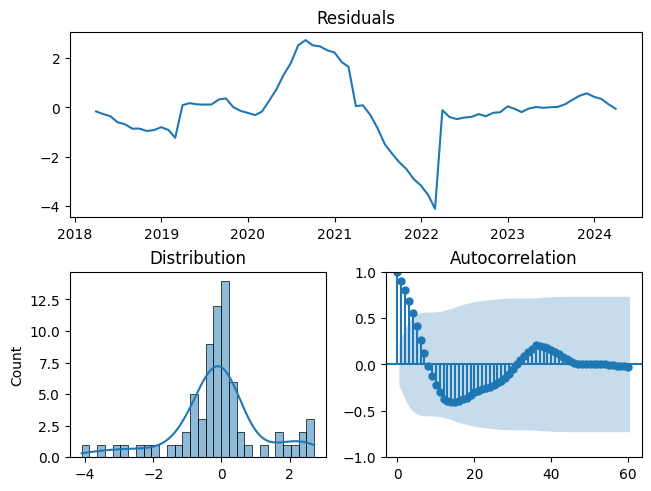

In [ ]:
# Diagnóstico de resíduos
residuos = dados_desemprego.loc[vc_sarima[1]["pred"].index] - vc_sarima[1]["pred"]
plot_residuals(residuals = residuos);
print(f"Média dos resíduos: {residuos.mean()}")

# Produção de previsões
---

In [ ]:
# Reestima melhor modelo com amostra completa
sarima.fit(y = dados_desemprego)

# Produz previsões
previsoes = sarima.predict_interval(steps = 12, alpha = 0.2)
previsoes

,pred,lower_bound,upper_bound
2024-05-01,7.140424,6.956714,7.324134
2024-06-01,6.783581,6.404180,7.162983
2024-07-01,6.596878,6.007048,7.186708
2024-08-01,6.428821,5.623562,7.234081
2024-09-01,6.191979,5.171886,7.212073
2024-10-01,5.920533,4.689449,7.151618
2024-11-01,5.655721,4.219340,7.092102
2024-12-01,5.466700,3.831710,7.101691
2025-01-01,5.766116,3.939657,7.592574
2025-02-01,6.052877,4.042208,8.063546


<Axes: title={'center': 'Taxa de desemprego no Brasil'}, ylabel='%'>

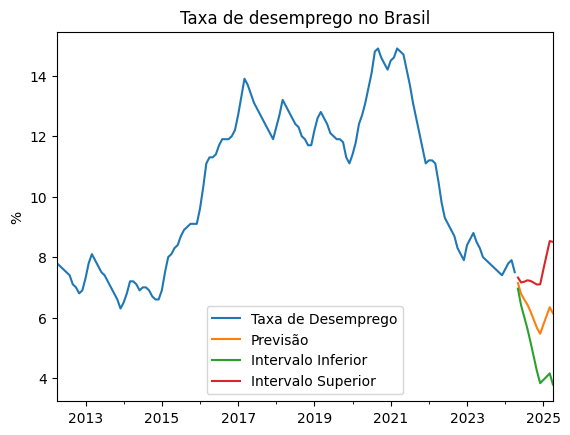

In [ ]:
# Visualização de dados
pd.concat(
    [dados_desemprego.rename("Taxa de Desemprego"),
     previsoes.pred.rename("Previsão"),
     previsoes.lower_bound.rename("Intervalo Inferior"),
     previsoes.upper_bound.rename("Intervalo Superior"),
    ],
    axis = "columns"
    ).plot(title = "Taxa de desemprego no Brasil", ylabel = "%")